Instead of latent code as input to transnet, use first image instead.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import random as rand
import copy

In [2]:
class Disentangler(nn.Module): 
    def __init__(self,encoder,decoder, transnet):
        super(Disentangler,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transnet = transnet #estimates trans parameters, contains exponential weights, creates matrices
        
    def forward(self,x, x0=None):
        if x0 == None:
            y = self.encoder(x)
            s = torch.zeros(x.size(0), self.encoder.latent_dim)
        else:
            y, s = self.transnet(x,x0)
        z = self.decoder(y)
        return z,y,s

class Encoder(nn.Module):
    def __init__(self, og_dim, latent_dim): #if images are nXn, og_dim = n^2.
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Encoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(og_dim, max(latent_dim, og_dim//4))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//4), max(latent_dim, og_dim//16))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//16), latent_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

class Decoder(nn.Module):  
    def __init__(self, og_dim, latent_dim):
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        super(Decoder,self).__init__()
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.fc1 = nn.Linear(latent_dim, max(latent_dim, og_dim//16))
        self.fc2 = nn.Linear(max(latent_dim, og_dim//16), max(latent_dim, og_dim//4))
        self.fc3 = nn.Linear(max(latent_dim, og_dim//4), og_dim)
    
    def forward(self,x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
class Transnet(nn.Module):
    def __init__(self, og_dim, latent_dim, trans_dim):
        super(Transnet,self).__init__()
        assert latent_dim <= og_dim, 'latent space must have lower dimension'
        assert trans_dim <= latent_dim, 'translation dimension must be subspace'
        self.og_dim = og_dim
        self.latent_dim = latent_dim
        self.trans_dim = trans_dim
        ttl_dim = 2*og_dim
#         ttl_dim = og_dim + latent_dim
        self.ttl_dim = ttl_dim
        self.fc1 = nn.Linear(ttl_dim, max(latent_dim, ttl_dim//4))
        self.fc2 = nn.Linear(max(latent_dim, ttl_dim//4), max(latent_dim, ttl_dim//16))
        self.fc3 = nn.Linear(max(latent_dim, ttl_dim//16), max(latent_dim, ttl_dim//64))
        self.fc4 = nn.Linear(max(latent_dim, ttl_dim//64), trans_dim)
        
    def forward(self,x,x0):
        x1 = torch.cat((x,x0),dim = 1) #create (B, N+M) tensor
        x1 = self.fc1(x1)
        x1 = F.relu(x1)
        x1 = self.fc2(x1)
        x1 = F.relu(x1)
        x1 = self.fc3(x1)
        x1 = F.relu(x1)
        x1 = self.fc4(x1)
        trans = torch.cat((x1,torch.zeros(x.size(0),self.latent_dim - self.trans_dim).to(device)), dim = 1)
        x0 = x0 + trans
        return x0, x1
        
class Autoencoder(nn.Module): 
    def __init__(self,encoder,decoder):
        super(Autoencoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self,x, x0=None):    
        x=self.encoder(x)
        x = self.decoder(x)
        return x
   

In [3]:
def make_model(og_dim, latent_dim, trans_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    trans = Transnet(og_dim, latent_dim, trans_dim)
    model = Disentangler(enc,dec,trans)
    return model

def make_autoenc(og_dim,latent_dim):
    enc = Encoder(og_dim, latent_dim)
    dec = Decoder(og_dim, latent_dim)
    model = Autoencoder(enc,dec)
    return model


In [703]:
def train(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set, beta = .7, sparse_par = 1e-2, opt_interval = 6): #transforms is 
    model.train()
    for epoch in range(epoch):
#         train_transnet = True
        for batch_idx, (data, target) in enumerate(train_loader):
            B = data.size(0)
#             if batch_idx % opt_interval == 0:
#                 for param in model.parameters():
#                     param.requires_grad = False
#                 for param in model.transnet.parameters():
#                     param.requires_grad = True

#             else:
#                     for param in model.parameters():
#                         param.requires_grad = True
#                     for param in model.transnet.parameters():
#                         param.requires_grad = False
#                 if train_transnet == True:
#                     for param in model.parameters():
#                         param.requires_grad = True
#                     for param in model.transnet.parameters():
#                         param.requires_grad = False
#                     train_transnet == False
#                 else:
#                     for param in model.parameters():
#                         param.requires_grad = False
#                     for param in model.transnet.parameters():
#                         param.requires_grad = True
#                     train_transnet == True
            loss = 0
            optimizer.zero_grad()
            for i in range(movie_len):
                if i == 0:
                    transform = rand.choice(transform_set)
                    prev_frame = curr_frame = data
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, latent_rep, trans_par = model(curr_frame)
                    first_frame = curr_frame.detach().clone().to(device)
#                     latent_rep = latent_rep.detach().clone()
#                     latent_rep = latent_rep.to(device)
                else:
                    curr_frame = transform(prev_frame)
                    prev_frame = curr_frame
                    curr_frame = curr_frame.flatten(1).to(device)
                    output, _ , trans_par = model(curr_frame, first_frame)
                loss = loss + (beta**i)*(F.mse_loss(output, curr_frame) + sparse_par*1/B*torch.norm(trans_par,1))
            loss.backward()
            optimizer.step()
            
            if batch_idx % opt_interval == 0:
                for param in model.parameters():
                    param.requires_grad = True
                for param in model.transnet.parameters():
                    param.requires_grad = False

            if batch_idx % print_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))

In [704]:
def train_enc(print_interval, model, device, train_loader, optimizer, epoch, movie_len, transform_set): #transforms is 
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        for i in range(movie_len):
            optimizer.zero_grad()
            if i == 0:
                prev_frame =  curr_frame = data
                transform = rand.choice(transform_set)
                curr_frame = curr_frame.flatten(1).to(device)
            else:
                curr_frame = transform(prev_frame)
                prev_frame = curr_frame
                curr_frame = curr_frame.flatten(1).to(device)
            output = model(curr_frame)
            loss = F.mse_loss(output, curr_frame)# + torch.norm(trans_par,1)
            loss.backward()
            optimizer.step()

        if batch_idx % print_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [705]:
hor_trans = transforms.Compose(
    [transforms.RandomAffine(0, translate = (.4,0))])

ver_trans = transforms.Compose(
    [transforms.RandomAffine(0,translate = (0,.4))])


transform_set = [hor_trans,ver_trans]

In [706]:
loader_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Lambda(lambda x: torch.clamp(x, min = 0)),
     transforms.Lambda(lambda x: x/torch.amax(x))
     ]
)
batch_size = 50
#(Down)Load MNIST
data_set = datasets.MNIST(root='./data', train=True, download=False, transform=loader_transform)

#Create data loader
data_loader = torch.utils.data.DataLoader(data_set, batch_size = batch_size, shuffle = True)


In [707]:
model_dis = make_model(28**2, latent_dim= 16, trans_dim = 2)

In [708]:
# model_dis = make_autoenc(28**2, latent_dim= 16)

In [709]:
device = torch.device(1)
torch.cuda.set_device(1)
model_dis = model_dis.to(device)
optimizer = torch.optim.Adam(model_dis.parameters(), lr=0.001) #e-1


In [711]:
train(200, model_dis, device, data_loader, optimizer, epoch = 10, movie_len = 3, transform_set = transform_set, sparse_par = 1e-2, opt_interval = 4, beta = .8)

In [690]:
model_dis.eval()
data, _ = next(iter(data_loader))
out_frames = torch.zeros(batch_size, 3, 28**2)
true_frames = torch.zeros(batch_size,3,28,28)
for i in range(1):
    if i == 0:
        transform = rand.choice(transform_set)
        prev_frame = curr_frame = data
        true_frames[:,i,:,:] = curr_frame.squeeze(1)
        curr_frame = curr_frame.flatten(1).to(device)
        out_frames[:,i,:], latent_rep, _ = model_dis(curr_frame)
#         latent_rep = latent_rep.detach().clone()
#         latent_rep = latent_rep.to(device)
    else:
        curr_frame = transform(prev_frame)
        true_frames[:,i,:,:] = curr_frame.squeeze(1)
        prev_frame = curr_frame
        curr_frame = curr_frame.flatten(1).to(device)
        out_frames[:,i,:], out_rep, _ = model_dis(curr_frame, latent_rep)

out_frames = out_frames.reshape(batch_size,3,28,28)
out_frames = out_frames.detach()

In [661]:
import matplotlib.pyplot as plt


(array([[28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.],
        [24.,  1.,  1.,  2.],
        [21.,  2.,  4.,  1.],
        [24.,  1.,  2.,  1.],
        [25.,  2.,  1.,  0.],
        [26.,  1.,  0.,  1.],
        [26.,  1.,  0.,  1.],
        [26.,  1.,  0.,  1.],
        [25.,  1.,  0.,  2.],
        [23.,  1.,  3.,  1.],
        [26.,  1.,  0.,  1.],
        [26.,  0.,  1.,  1.],
        [26.,  0.,  1.,  1.],
        [26.,  1.,  0.,  1.],
        [27.,  0.,  0.,  1.],
        [27.,  0.,  0.,  1.],
        [26.,  0.,  1.,  1.],
        [26.,  0.,  0.,  2.],
        [25.,  1.,  1.,  1.],
        [21.,  3.,  2.,  2.],
        [22.,  1.,  2.,  3.],
        [28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.],
        [28.,  0.,  0.,  0.]]),
 array([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float32),
 <a list of 28 BarContainer objects>)

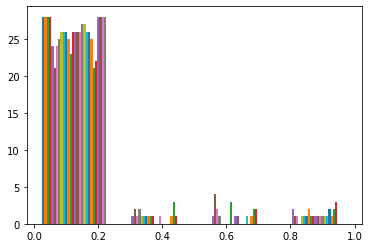

In [662]:
plt.hist(true_frames[ix,0],bins=4)

(array([[ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.],
        [ 0.,  0., 28.,  0.]]),
 array([-0.5 , -0.25,  0.  ,  0.25,  0.5 ], dtype=float32),
 <a list of 28 BarContainer objects>)

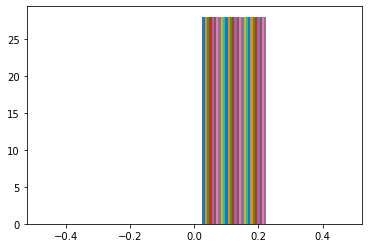

In [663]:
plt.hist(true_frames[ix,1], bins=4)

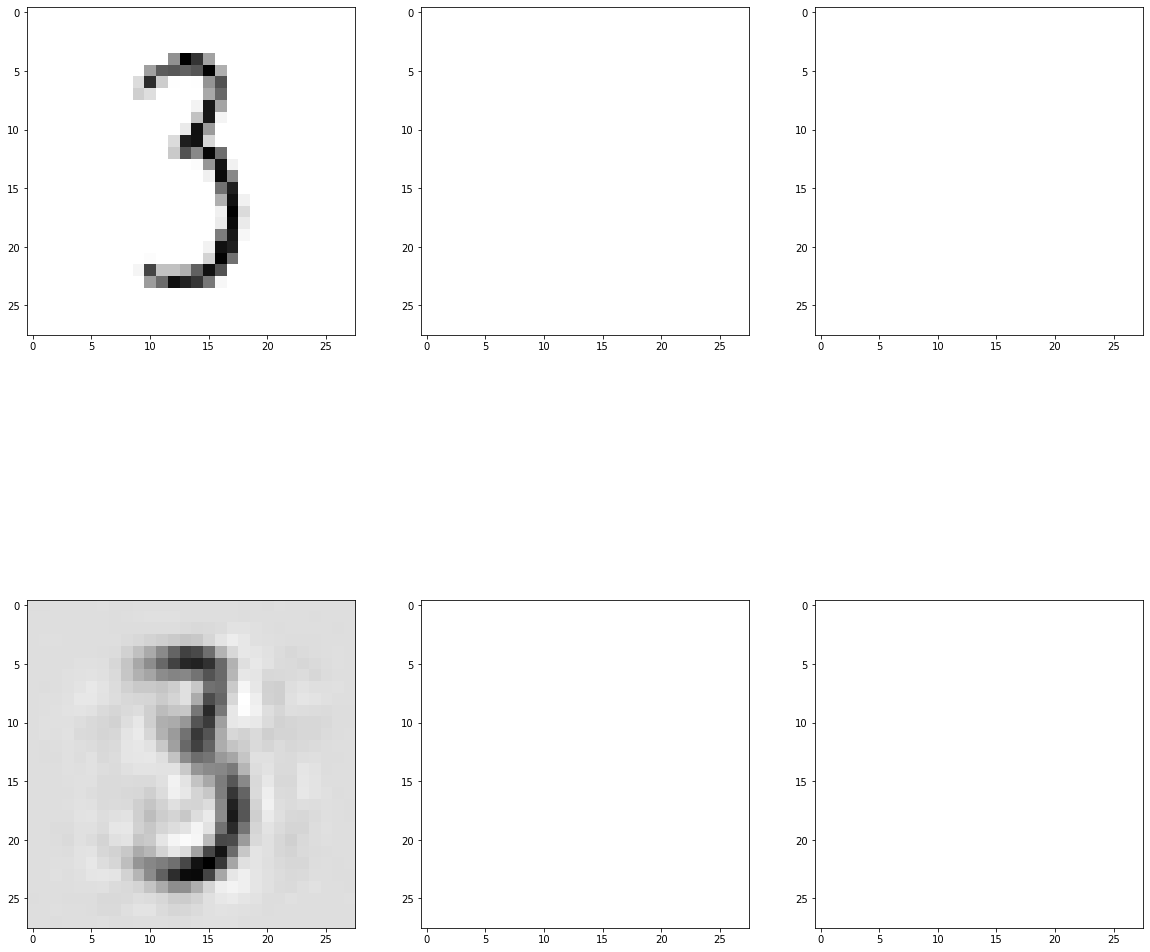

In [664]:
ix = 0
fig = plt.figure(figsize=(20,20)) #image sequence from dataset
for i in range(3):
        fig.add_subplot(2,3,i+1)
        plt.imshow(true_frames[ix,i],cmap = "Greys")
        fig.add_subplot(2,3,i+4)
        plt.imshow(out_frames[ix,i], cmap = 'Greys')

In [378]:
true_frames[:,0,:,:].shape

torch.Size([50, 28, 28])